<a href="https://colab.research.google.com/github/jie-feng1115/pet_finder_competition/blob/master/Jie/Jie_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
import numpy as np 
import pandas as pd 
import os
import json
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from PIL import Image
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import gc
#from catboost import CatBoostClassifier
from tqdm import tqdm_notebook
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import random
import warnings
warnings.filterwarnings("ignore")
from functools import partial
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)
import os
import scipy as sp
from math import sqrt
from collections import Counter
from sklearn.metrics import confusion_matrix as sk_cmatrix

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import RandomForestClassifier
#import langdetect
#import eli5
from IPython.display import display


In [0]:
breeds = pd.read_csv('/content/drive/My Drive/ML Team 2 Project/PetFinder Project/petfinder_competition_data_folder/breed_labels.csv')
colors = pd.read_csv('/content/drive/My Drive/ML Team 2 Project/PetFinder Project/petfinder_competition_data_folder/color_labels.csv')
states = pd.read_csv('/content/drive/My Drive/ML Team 2 Project/PetFinder Project/petfinder_competition_data_folder/state_labels.csv')
train = pd.read_csv('/content/drive/My Drive/ML Team 2 Project/PetFinder Project/petfinder_competition_data_folder/train/train.csv')
test = pd.read_csv('/content/drive/My Drive/ML Team 2 Project/PetFinder Project/petfinder_competition_data_folder/test/test.csv')
sub = pd.read_csv('/content/drive/My Drive/ML Team 2 Project/PetFinder Project/petfinder_competition_data_folder/test/sample_submission.csv')

train['dataset_type'] = 'train'
test['dataset_type'] = 'test'
all_data = pd.concat([train, test])

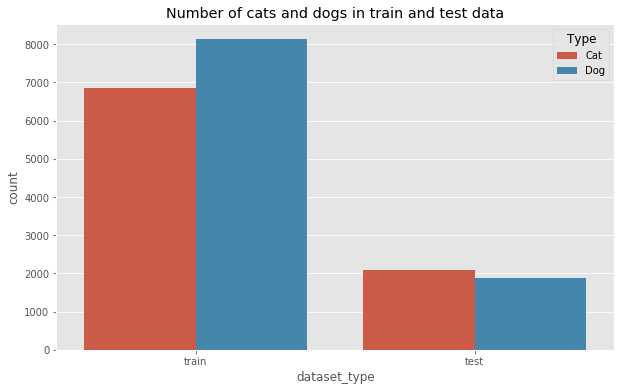

In [101]:
all_data['Type'] = all_data['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')
plt.figure(figsize=(10, 6));
sns.countplot(x='dataset_type', data=all_data, hue='Type');
plt.title('Number of cats and dogs in train and test data');

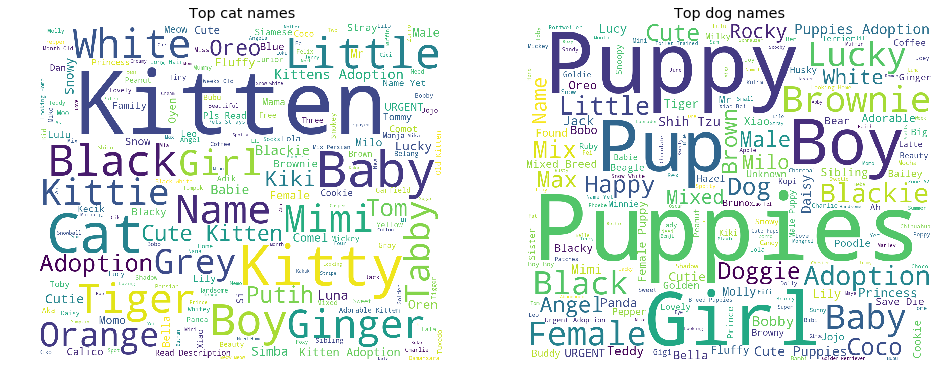

In [102]:
fig, ax = plt.subplots(figsize = (16, 12))
plt.subplot(1, 2, 1)
text_cat = ' '.join(all_data.loc[all_data['Type'] == 'Cat', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_cat)
plt.imshow(wordcloud)
plt.title('Top cat names')
plt.axis("off")

plt.subplot(1, 2, 2)
text_dog = ' '.join(all_data.loc[all_data['Type'] == 'Dog', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_dog)
plt.imshow(wordcloud)
plt.title('Top dog names')
plt.axis("off")

plt.show()

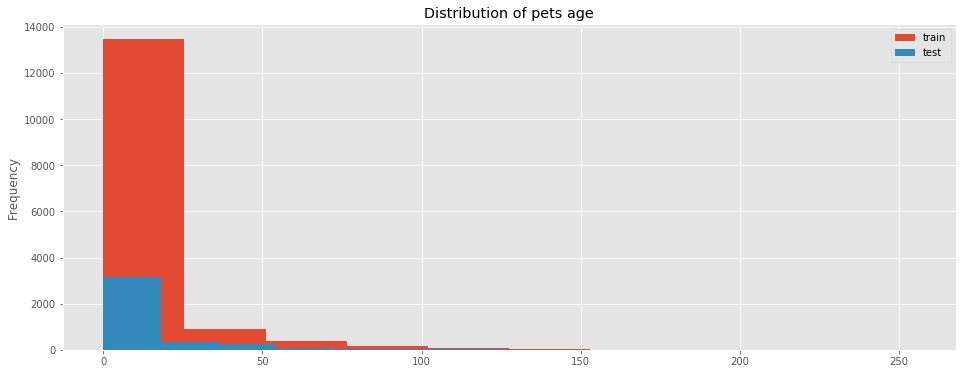

In [103]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 1, 1)
plt.title('Distribution of pets age');
train['Age'].plot('hist', label='train');
test['Age'].plot('hist', label='test');
plt.legend();

# plt.subplot(1, 2, 2)
# plt.title('Distribution of pets age (log)');
# np.log1p(train['Age']).plot('hist', label='train');
# np.log1p(test['Age']).plot('hist', label='test');
# plt.legend();

In [104]:
all_data.describe()

,AdoptionSpeed,Age,Breed1,Breed2,Color1,Color2,Color3,Dewormed,Fee,FurLength,Gender,Health,MaturitySize,PhotoAmt,Quantity,State,Sterilized,Vaccinated,VideoAmt
count,14993.000000,18941.000000,18941.000000,18941.000000,18941.000000,18941.000000,18941.000000,18941.000000,18941.000000,18941.000000,18941.000000,18941.000000,18941.000000,18941.000000,18941.000000,18941.000000,18941.000000,18941.000000,18941.000000
mean,2.516441,10.683966,264.805871,70.539201,2.233726,3.250515,1.919381,1.547754,22.528589,1.467346,1.777520,1.038066,1.854179,3.872604,1.586558,41347.068634,1.909033,1.725463,0.058022
std,1.177265,18.247672,59.880084,121.002279,1.743388,2.734236,2.996918,0.693462,80.637133,0.602049,0.683895,0.203656,0.552772,3.517535,1.502257,32.990416,0.570863,0.667008,0.356063
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,41324.000000,1.000000,1.000000,0.000000
25%,2.000000,2.000000,265.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,41326.000000,2.000000,1.000000,0.000000
50%,2.000000,3.000000,266.000000,0.000000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,2.000000,1.000000,2.000000,3.000000,1.000000,41326.000000,2.000000,2.000000,0.000000
75%,4.000000,12.000000,307.000000,128.000000,3.000000,6.000000,5.000000,2.000000,0.000000,2.000000,2.000000,1.000000,2.000000,5.000000,1.000000,41401.000000,2.000000,2.000000,0.000000
max,4.000000,255.000000,307.000000,307.000000,7.000000,7.000000,7.000000,3.000000,3000.000000,3.000000,3.000000,3.000000,4.000000,30.000000,20.000000,41415.000000,3.000000,3.000000,9.000000


In [105]:
for key in train.columns:
    print(key)
    #print(train.get(key).count)

Type
Name
Age
Breed1
Breed2
Gender
Color1
Color2
Color3
MaturitySize
FurLength
Vaccinated
Dewormed
Sterilized
Health
Quantity
Fee
State
RescuerID
VideoAmt
Description
PetID
PhotoAmt
AdoptionSpeed
dataset_type


In [0]:
def categorical_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', verbose=True):
    '''
    Helper function that gives a quick summary of a given column of categorical data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data, y would be the count
    y: str. vertical axis to plot the labels of categorical data, x would be the count
    hue: str. if you want to compare it another variable (usually the target variable)
    palette: array-like. Colour of the plot
    Returns
    =======
    Quick Stats of the data and also the count plot
    '''
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.countplot(x=x, y=y, hue=hue, data=dataframe, palette=palette)
    plt.show()

In [0]:
main_count = train['AdoptionSpeed'].value_counts(normalize=True).sort_index()
def prepare_plot_dict(df, col, main_count):
    """
    Preparing dictionary with data for plotting.
    
    I want to show how much higher/lower are the rates of Adoption speed for the current column comparing to base values (as described higher),
    At first I calculate base rates, then for each category in the column I calculate rates of Adoption speed and find difference with the base rates.
    
    """
    main_count = dict(main_count)
    plot_dict = {}
    for i in df[col].unique():
        val_count = dict(df.loc[df[col] == i, 'AdoptionSpeed'].value_counts().sort_index())

        for k, v in main_count.items():
            if k in val_count:
                plot_dict[val_count[k]] = ((val_count[k] / sum(val_count.values())) / main_count[k]) * 100 - 100
            else:
                plot_dict[0] = 0

    return plot_dict

def make_count_plot(df, x, hue='AdoptionSpeed', title='', main_count=main_count):
    """
    Plotting countplot with correct annotations.
    """
    g = sns.countplot(x=x, data=df, hue=hue);
    plt.title(f'AdoptionSpeed {title}');
    ax = g.axes

    plot_dict = prepare_plot_dict(df, x, main_count)

    for p in ax.patches:
        h = p.get_height() if str(p.get_height()) != 'nan' else 0
        text = f"{plot_dict[h]:.0f}%" if plot_dict[h] < 0 else f"+{plot_dict[h]:.0f}%"
        ax.annotate(text, (p.get_x() + p.get_width() / 2., h),
             ha='center', va='center', fontsize=11, color='green' if plot_dict[h] > 0 else 'red', rotation=0, xytext=(0, 10),
             textcoords='offset points')  

In [108]:
train['AdoptionSpeed'].value_counts(normalize=True).sort_index()

0    0.027346
1    0.206096
2    0.269259
3    0.217368
4    0.279931
Name: AdoptionSpeed, dtype: float64

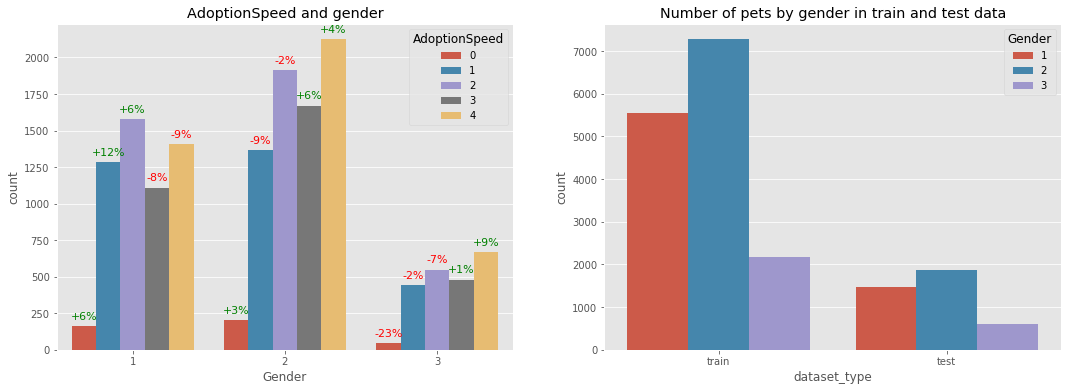

In [109]:
plt.figure(figsize=(18, 6));
plt.subplot(1, 2, 1)
make_count_plot(df=train, x='Gender', title='and gender')

plt.subplot(1, 2, 2)
sns.countplot(x='dataset_type', data=all_data, hue='Gender');
plt.title('Number of pets by gender in train and test data');

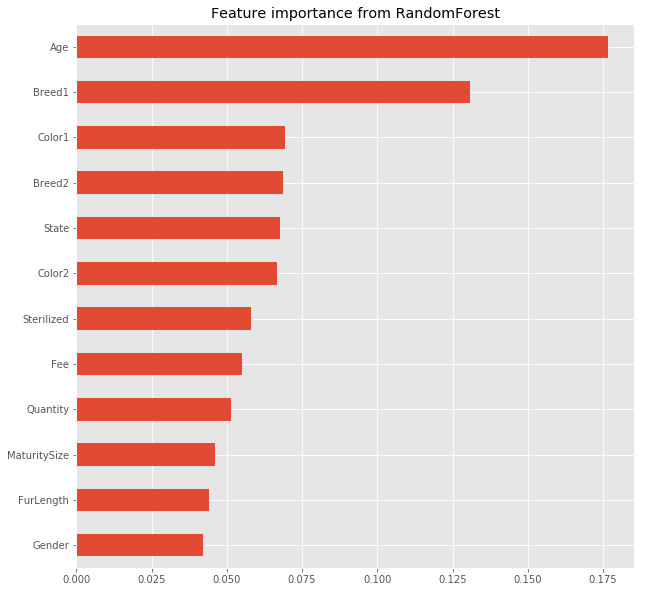

In [110]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 500, max_depth=12)
x_train = train[['Age','Gender','Breed1','Breed2','Color1', 'Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','Quantity','Fee','State']]
y_train = train[['AdoptionSpeed']]
rf_clf.fit(x_train, y_train)
rf_y_pred = rf_clf.predict(x_train)
pd.Series(rf_clf.feature_importances_, index = x_train.columns).nlargest(12).plot(kind = 'barh',
                                                                                 figsize = (10, 10),
                                                                                title = 'Feature importance from RandomForest').invert_yaxis();

In [111]:
x_train.head()

,Age,Gender,Breed1,Breed2,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State
0,3,1,299,0,1,7,0,1,1,2,2,2,1,1,100,41326
1,1,1,265,0,1,2,0,2,2,3,3,3,1,1,0,41401
2,1,1,307,0,2,7,0,2,2,1,1,2,1,1,0,41326
3,4,2,307,0,1,2,0,2,1,1,1,2,1,1,150,41401
4,1,1,307,0,1,0,0,2,1,2,2,2,1,1,0,41326


In [0]:
# from sklearn.datasets import make_hastie_10_2
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.inspection import plot_partial_dependence


# clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
#      max_depth=1, random_state=0).fit(x, y)

#plot_partial_dependence(clf, X, ['Age','Gender','Breed1','Breed2','Color1', 'Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','Quantity','Fee','State'],) 

In [113]:
for name in train.columns:
  print(name)
  print(train[name].unique())

Type
[2 1]
Name
['Nibble' 'No Name Yet' 'Brisco' ... 'Monkies' 'Ms Daym' 'Fili']
Age
[  3   1   4  12   0   2  78   6   8  10  36  14  24   5  72  60   9  48
  62  47  19 120  32   7  17  22  16  13  11  37  18  55  20  28  74  53
  25  84  76  30 132  96  46  15  50  56  54  23  92  29  27  49  44 144
  21  31  41  51  65  34 135  39  52  42 108  81  26  38  69 212  33  75
  95  80  63  61 255  89  91  35 117  73 122 123  64  87 112 156  66  67
  77 180  82  86  40  57 168 102  45 147  68  85  88  43 238 100]
Breed1
[299 265 307 266 264 218 114 285 189 205 292 128 243 213 141 173 207 250
 119 195 109 206  70 103 303  78 254  10  20 305 283 306 288  69 179  31
 247 200 248  26  25   0 129 202  72  24 284 286 152 277  44  75  64  60
 296 185 300  76 139 242 294 276 102 182 289 145 178 233  82  49 239 231
 169 111 232 270 267 268 251  58 155 295 304 147 245 282  21 215 192 154
  71 272 241 262 249 273 108 240  83 293  39  50  93   1  17 252 224 100
 280  42  15 190  19 274 117 263 290 25

In [114]:
train.isnull().sum()

Type                0
Name             1257
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        12
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dataset_type        0
dtype: int64

In [0]:
df = train.drop(columns=['Name', 'Description','RescuerID','PetID','dataset_type'])

In [116]:
df['Type'].dtype.kind == 'i'

True

In [0]:
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# df.loc[:, 'RescuerID'] = labelencoder.fit_transform(df.loc[:, 'RescuerID'])

In [0]:
X = df.values

In [0]:
types = np.unique(X[:,0])

In [120]:
X.shape

(14993, 20)

In [121]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categories=[types])

#X = ohe.fit_transform(X[:,0].reshape(-1,1)).toarray()
#X = ohe.fit_transform(X).toarray()
x_transformed = X[:,-1].reshape(-1,1)
count = 0
for i, name in enumerate(df.columns):
  if df[name].dtype.kind == 'i':
    print(name)
    print(df[name].unique().shape[0])
    print("index"+str(i))
    uniques = np.unique(X[:,i])
    print("uniques "+str(uniques))
    ohe = OneHotEncoder(categories=[uniques])
    tmp = ohe.fit_transform(X[:,i].reshape(-1, 1)).toarray()
    print(tmp.shape)
    print(x_transformed.shape)
    x_transformed = np.append(tmp, x_transformed, axis=1) 
  elif df[name].dtype.kind == 'f':
    x_transformed = np.append(X[:,i].reshape(-1,1), x_transformed, axis=1) 
    
print(x_transformed.shape)
    

#X = np.append(tmp, X[:,-1].reshape(-1,1), axis=1)

Type
2
index0
uniques [1. 2.]
(14993, 2)
(14993, 1)
Age
106
index1
uniques [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  72.  73.
  74.  75.  76.  77.  78.  80.  81.  82.  84.  85.  86.  87.  88.  89.
  91.  92.  95.  96. 100. 102. 108. 112. 117. 120. 122. 123. 132. 135.
 144. 147. 156. 168. 180. 212. 238. 255.]
(14993, 106)
(14993, 3)
Breed1
176
index2
uniques [  0.   1.   3.   5.   7.  10.  11.  15.  16.  17.  18.  19.  20.  21.
  23.  24.  25.  26.  31.  32.  39.  42.  44.  49.  50.  56.  58.  60.
  61.  64.  65.  69.  70.  71.  72.  75.  76.  78.  81.  82.  83.  85.
  88.  93.  97.  98.  99. 100. 102. 103. 105. 108. 109. 111. 114. 117.
 119. 122. 123. 125. 128. 129. 130. 132. 139. 141. 1

In [122]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categories=[types])


for i, name in enumerate(df.columns):
  if df[name].dtype.kind == 'i':
    df.rename(columns={name: 'cat_'+name}, inplace=True)
  
    
df.rename(columns={ 'cat_Age': 'Age'}, inplace=True)
df.rename(columns={ 'cat_VideoAmt': 'VideoAmt'}, inplace=True)
df.rename(columns={ 'cat_AdoptionSpeed': 'AdoptionSpeed'}, inplace=True)

df.columns
    

Index(['cat_Type', 'Age', 'cat_Breed1', 'cat_Breed2', 'cat_Gender',
       'cat_Color1', 'cat_Color2', 'cat_Color3', 'cat_MaturitySize',
       'cat_FurLength', 'cat_Vaccinated', 'cat_Dewormed', 'cat_Sterilized',
       'cat_Health', 'cat_Quantity', 'cat_Fee', 'cat_State', 'VideoAmt',
       'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [124]:
y = df.AdoptionSpeed.values
print(y)

[2 0 3 ... 3 4 3]


In [0]:
df.drop(['AdoptionSpeed'], inplace=True, axis=1)

In [0]:
x = df.values

In [0]:
x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [0]:
categorical_features = [c for c, col in enumerate(train.columns) if 'cat' in col]
train_data = lightgbm.Dataset(x, label=y, categorical_feature=categorical_features)
test_data = lightgbm.Dataset(x_test, label=y_test)

In [0]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

In [130]:
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[1]	valid_0's auc: 0.541945
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.561304
[3]	valid_0's auc: 0.583668
[4]	valid_0's auc: 0.586467
[5]	valid_0's auc: 0.592751
[6]	valid_0's auc: 0.595688
[7]	valid_0's auc: 0.599058
[8]	valid_0's auc: 0.607208
[9]	valid_0's auc: 0.609871
[10]	valid_0's auc: 0.60794
[11]	valid_0's auc: 0.611033
[12]	valid_0's auc: 0.61174
[13]	valid_0's auc: 0.609522
[14]	valid_0's auc: 0.611364
[15]	valid_0's auc: 0.611702
[16]	valid_0's auc: 0.612724
[17]	valid_0's auc: 0.61604
[18]	valid_0's auc: 0.616031
[19]	valid_0's auc: 0.61706
[20]	valid_0's auc: 0.618237
[21]	valid_0's auc: 0.618078
[22]	valid_0's auc: 0.621765
[23]	valid_0's auc: 0.622967
[24]	valid_0's auc: 0.624899
[25]	valid_0's auc: 0.620638
[26]	valid_0's auc: 0.618264
[27]	valid_0's auc: 0.617131
[28]	valid_0's auc: 0.616997
[29]	valid_0's auc: 0.620547
[30]	valid_0's auc: 0.623051
[31]	valid_0's auc: 0.621182
[32]	valid_0's auc: 0.621236
[33]	valid_0's auc: 0.

In [93]:
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

y = x_transformed[:,-1]
X = x_transformed[:,:-1]
print(y.shape)
print(X.shape)

(14993,)
(14993, 583)


In [0]:
x, x_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)